In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

##   Problem Statement

Suppose you are starting a company that grows and sells wild mushrooms. 
- Since not all mushrooms are edible, you'd like to be able to tell whether a given mushroom is edible or poisonous based on it's physical attributes
- You have some existing data that you can use for this task. 

Can you use the data to help you identify which mushrooms can be sold safely? 

Note: The dataset used is for illustrative purposes only. It is not meant to be a guide on identifying edible mushrooms.



##  Dataset

You will start by loading the dataset for this task. The dataset you have collected is as follows:

|                                                     | Cap Color | Stalk Shape | Solitary | Edible |
|:---------------------------------------------------:|:---------:|:-----------:|:--------:|:------:|
| <img src="images2/0.png" alt="drawing" width="50"/> |   Brown   |   Tapering  |    Yes   |    1   |
| <img src="images2/1.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    Yes   |    1   |
| <img src="images2/2.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    No    |    0   |
| <img src="images2/3.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    No    |    0   |
| <img src="images2/4.png" alt="drawing" width="50"/> |   Brown   |   Tapering  |    Yes   |    1   |
| <img src="images2/5.png" alt="drawing" width="50"/> |    Red    |   Tapering  |    Yes   |    0   |
| <img src="images2/6.png" alt="drawing" width="50"/> |    Red    |  Enlarging  |    No    |    0   |
| <img src="images2/7.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    Yes   |    1   |
| <img src="images2/8.png" alt="drawing" width="50"/> |    Red    |   Tapering  |    No    |    1   |
| <img src="images2/9.png" alt="drawing" width="50"/> |   Brown   |  Enlarging  |    No    |    0   |


-  You have 10 examples of mushrooms. For each example, you have
    - Three features
        - Cap Color (`Brown` or `Red`),
        - Stalk Shape (`Tapering (as in \/)` or `Enlarging (as in /\)`), and
        - Solitary (`Yes` or `No`)
    - Label
        - Edible (`1` indicating yes or `0` indicating poisonous)

<a name="3.1"></a>
###  One hot encoded dataset
For ease of implementation, we have one-hot encoded the features (turned them into 0 or 1 valued features)

|                                                    | Brown Cap | Tapering Stalk Shape | Solitary | Edible |
|:--------------------------------------------------:|:---------:|:--------------------:|:--------:|:------:|
| <img src="images2/0.png" alt="drawing" width="50"/> |     1     |           1          |     1    |    1   |
| <img src="images2/1.png" alt="drawing" width="50"/> |     1     |           0          |     1    |    1   |
| <img src="images2/2.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
| <img src="images2/3.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |
| <img src="images2/4.png" alt="drawing" width="50"/> |     1     |           1          |     1    |    1   |
| <img src="images2/5.png" alt="drawing" width="50"/> |     0     |           1          |     1    |    0   |
| <img src="images2/6.png" alt="drawing" width="50"/> |     0     |           0          |     0    |    0   |
| <img src="images2/7.png" alt="drawing" width="50"/> |     1     |           0          |     1    |    1   |
| <img src="images2/8.png" alt="drawing" width="50"/> |     0     |           1          |     0    |    1   |
| <img src="images2/9.png" alt="drawing" width="50"/> |     1     |           0          |     0    |    0   |


Therefore,
- `X_train` contains three features for each example 
    - Brown Color (A value of `1` indicates "Brown" cap color and `0` indicates "Red" cap color)
    - Tapering Shape (A value of `1` indicates "Tapering Stalk Shape" and `0` indicates "Enlarging" stalk shape)
    - Solitary  (A value of `1` indicates "Yes" and `0` indicates "No")

- `y_train` is whether the mushroom is edible 
    - `y = 1` indicates edible
    - `y = 0` indicates poisonous

In [16]:
X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])

#### View the variables

In [17]:
print("First few elements of X_train:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First few elements of X_train:
 [[1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 1 1]]
Type of X_train: <class 'numpy.ndarray'>


In [18]:
print("First few elements of y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

First few elements of y_train: [1 1 0 0 1]
Type of y_train: <class 'numpy.ndarray'>


#### Check the dimensions of your variables


In [19]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(X_train))

The shape of X_train is: (10, 3)
The shape of y_train is:  (10,)
Number of training examples (m): 10


## Decision Tree Refresher

In [20]:
def compute_entropy(y):
    """
    Computes the entropy for 
    
    Args:
       y (ndarray): Numpy array indicating whether each example at a node is
           edible (`1`) or poisonous (`0`)
       
    Returns:
        entropy (float): Entropy at that node
        
    """
    entropy = 0.
    
    if len(y) != 0:
        p_1 = sum(y)/len(y)
        
        if p_1 == 0 or p_1 == 1:
            entropy = 0
        else:
            entropy = -p_1 * np.log2(p_1) - (1 - p_1) * np.log2(1 - p_1)
    
    return entropy

###  Split dataset

In [21]:
def split_dataset(X, node_indices, feature):
    """
    Splits the data at the given node into
    left and right branches
    
    Args:
        X (ndarray):             Data matrix of shape(n_samples, n_features)
        node_indices (list):     List containing the active indices. I.e, the samples being considered at this step.
        feature (int):           Index of feature to split on
    
    Returns:
        left_indices (list):     Indices with feature value == 1
        right_indices (list):    Indices with feature value == 0
    """
    
    left_indices = []
    right_indices = []
    
    for i in node_indices:
        if X[i,feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
                            
    return left_indices, right_indices

In [22]:
def generate_node_image(node_indices):
    image_paths = ["images2/%d.png" % idx for idx in node_indices]
    images = [Image.open(x) for x in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    
    new_im = new_im.resize((int(total_width*len(node_indices)/10), int(max_height*len(node_indices)/10)))
    
    return new_im

In [23]:
def generate_split_viz(node_indices, left_indices, right_indices, feature):
    
    G=nx.DiGraph()
    
    indices_list = [node_indices, left_indices, right_indices]
    for idx, indices in enumerate(indices_list):
        G.add_node(idx,image= generate_node_image(indices))

    G.add_edge(0,1)
    G.add_edge(0,2)

    pos = graphviz_layout(G, prog="dot")

    fig=plt.figure()
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax, arrows=True, arrowsize=40)
    
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    feature_name = ["Brown Cap", "Tapering Stalk Shape", "Solitary"][feature]
    ax_name = ["Splitting on %s" % feature_name , "Left: %s = 1" % feature_name, "Right: %s = 0" % feature_name]
    for idx, n in enumerate(G):
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        piesize = len(indices_list[idx])/9
        p2=piesize/2.0
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.axis('off')
        a.set_title(ax_name[idx])
    ax.axis('off')
    plt.show()

CASE 1:
Left indices:  [0, 1, 2, 3, 4, 7, 9]
Right indices:  [5, 6, 8]


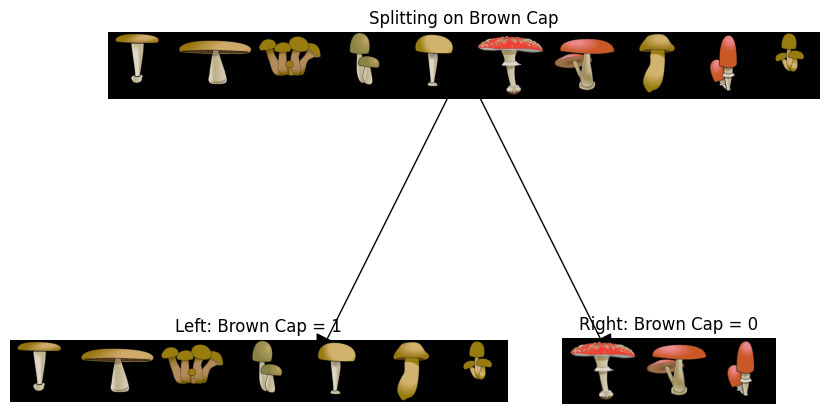


CASE 2:
Left indices:  [0, 2, 4]
Right indices:  [6, 8]


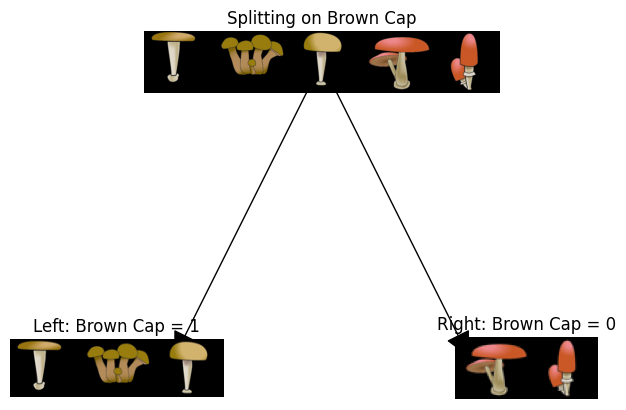

In [24]:
# Case 1

root_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Feel free to play around with these variables
# The dataset only has three features, so this value can be 0 (Brown Cap), 1 (Tapering Stalk Shape) or 2 (Solitary)
feature = 0

left_indices, right_indices = split_dataset(X_train, root_indices, feature)

print("CASE 1:")
print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

# Visualize the split 
generate_split_viz(root_indices, left_indices, right_indices, feature)

print()

# Case 2

root_indices_subset = [0, 2, 4, 6, 8]
left_indices, right_indices = split_dataset(X_train, root_indices_subset, feature)

print("CASE 2:")
print("Left indices: ", left_indices)
print("Right indices: ", right_indices)

# Visualize the split 
generate_split_viz(root_indices_subset, left_indices, right_indices, feature)

###  Calculate information gain

The `compute_information_gain()` is:

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$

where 
- $H(p_1^\text{node})$ is entropy at the node 
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch, respectively

In [25]:
def compute_information_gain(X, y, node_indices, feature):
    
    """
    Compute the information of splitting the node on a given feature
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        feature (int):           Index of feature to split on
   
    Returns:
        cost (float):        Cost computed
    
    """    
    # Split dataset
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    # Some useful variables
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
        
    node_entropy = compute_entropy(y_node)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    
    information_gain = node_entropy - (w_left * left_entropy + w_right * right_entropy)
        
    return information_gain

###  Get best split
Now let's write a function to get the best feature to split on by computing the information gain from each feature as we did above and returning the feature that gives the maximum information gain

In [26]:
def get_best_split(X, y, node_indices):   
    """
    Returns the optimal feature and threshold value
    to split the node data 
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
    """    
    
    # Some useful variables
    num_features = X.shape[1]
    
    best_feature = -1
    
    max_info_gain = 0
    for i in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, i)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = i
   
    return best_feature

## Building the tree

In [27]:
tree = []

def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    This function just prints the tree.
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree. 
        current_depth (int):    Current depth. Parameter used during recursive call.
   
    """ 

    # Maximum depth reached - stop splitting
    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   
    # Otherwise, get best split and split the data
    # Get the best feature and threshold at this node
    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    
    # Split the dataset at the best feature
    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    # continue splitting the left and the right child. Increment current depth
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1)

In [28]:
build_tree_recursive(X_train, y_train, root_indices, "Root", max_depth=2, current_depth=0)

 Depth 0, Root: Split on feature: 2
- Depth 1, Left: Split on feature: 0
  -- Left leaf node with indices [0, 1, 4, 7]
  -- Right leaf node with indices [5]
- Depth 1, Right: Split on feature: 1
  -- Left leaf node with indices [8]
  -- Right leaf node with indices [2, 3, 6, 9]
